In [1]:
#import all the necessary libaries

#General processing and visualization 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#For the forecasting models 
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.tree  import DecisionTreeRegressor
from tqdm import tqdm

#For the clustering 
from tslearn.clustering import TimeSeriesKMeans
from scipy.stats import skew
from scipy.stats import kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist
from fastdtw import fastdtw

#For evaluation of models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,mean_squared_error

#For evaluation and understanding of the clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
from itertools import combinations
from scipy.stats import wilcoxon

#Set the style of the visualizations
plt.style.use("seaborn")

#Ignore some warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Data preparation 

In [2]:
#Import the data
file_path = r"C:\Users\annie\Desktop\uni\thesis\Untitled Folder\Bookings_Sunweb_Sun_NL.csv" #replace with your own
data = pd.read_csv(file_path, delimiter=";")

#Remove data when no destination airport is given
data = data[data["DestinationAirport"]!="0"] 

# Make two distinct columns for departure and booking : week and year
data[['DepartureYear', 'DepartureWeek']] = data["DepartureYearWeek"].str.split('_', expand=True).apply(pd.to_numeric)
data[['BookingYear', 'BookingWeek']] = data["BookingYearWeek"].str.split('_', expand=True).apply(pd.to_numeric)

# Compute total passengers per holiday package and add columnn "Pax_total"
data = data.merge(
    data.groupby(["DestinationAirport", "DepartureYearWeek"], as_index=False)['Pax'].sum().rename(columns={'Pax': 'Pax_total'}),
    on=["DestinationAirport", "DepartureYearWeek"]
)

#Remove all holiday packages departing on the 53rd week of any year (Note:2015 was a leap year)
data = data[~(data["DepartureWeek"] == 53)]

#Remove all bookings made in the 53rd week of any year 
data = data[~(data["BookingWeek"] == 53)]

#Create percent column : representing the percent of bookings made in a specific booking week 
data['percent'] = data['Pax'] / data["Pax_total"]

def calculate_weeks_in_advance(row):
    '''
    Given a row, calculate how many weeks in advance of the departure week was that booking made. 
    Parameters:
    - row : one row of the dataframe
    Returns :
    - number that represents the weeks in advance 
    '''
    # If the booking and departure are in the same year, simply subtract the booking week from the departure week
    if row["DepartureYear"] == row["BookingYear"]:
        return row["DepartureWeek"] - row["BookingWeek"]
    else:
        # If the booking and departure span different years, calculate the weeks in advance by accounting for the full years and weeks difference
        return (row["DepartureYear"] - row["BookingYear"]) * 52 - (row["BookingWeek"] - row["DepartureWeek"])

# Apply the function calculate_weeks_in_advance to create a new column 'advance' representing the weeks in advance 
data["advance"] = data.apply(calculate_weeks_in_advance, axis=1)


In [3]:
def make_X(data):
    '''
    Generate a DataFrame that is indexed per holiday package with the following columns:
    1. DestinationCountry: The country of the destination airport. e.g. "Spain"
    2. DestinationAirport: The code of the destination airport.  e.g. "ACE"
    3. DepartureYearWeek: The combination of the departure year and week. e.g. "2015 _ 51"
    4. DepartureYear: The year of departure. e.g. 2015
    5. DepartureWeek: The week of departure.  e.g. 51
    6. Pax_total: The total number of passengers.  e.g. 243
    7. BookingsList: An array of length 104 representing the percent of bookings made for each booking week in advance.
       E.g., at index 0: 0.0041 means 0.41% of the total bookings were made 0 weeks in advance(same week as departure).
    8. WeekList: An array of length 104 representing the booking week of the year when the booking occurred.
        E.g., at index 0: 51, the week of departure is booking week 51 , at index 1: 50 , 1 week before departure is booking week 50
        
    Note: The lists come in handy for reducing the high-dimensionality of the data instead of having one row per booking week,
    there is one row per holiday package 
    
    Parameters:
    - data: The input DataFrame containing the booking data
    Returns:
    - df: The generated DataFrame with the specified columns with the lists, indexed by each holiday package
    '''
    
    result = []

    # A unique holiday package is defined as a combination of destination airport and departure year-week
    holiday_packages = data.groupby(['DestinationAirport', 'DepartureYearWeek'])

    # Iterate through each unique holiday package
    for (destination, dep), destination_data in holiday_packages:
        # Filter the data for the current destination and departure year-week
        destination_data = data[(data['DestinationAirport'] == destination) & (data["DepartureYearWeek"] == dep)]

        week_numbers = []  # Initialize a list to hold the week numbers in descending order
        number = destination_data["DepartureWeek"].iloc[0]  # The starting point for the booking weeks is the departure week

        # Create a descending list of the booking weeks
        while len(week_numbers) < 104:  # Considering a 2-year horizon, hence 104 weeks
            week_numbers.append(number)  # Append the current number to the list
            number -= 1  # Decrement the current number to get the next week in descending order
            if number == 0:  # If the current number reaches 0, restart from week 52 (end of the year)
                number = 52

        bookings_per_week = np.zeros(104)  # Initialize an array to track bookings for the 104-week horizon, starting with zero bookings

        # Fill the bookings array with the booking percentages
        for index, row in destination_data.iterrows():
            advance = row["advance"]  # Calculate the number of weeks in advance the booking was made
            bookings_per_week[advance] = row['percent']  # Set the booking percentage for the corresponding week in advance

        # Append the results for the current holiday package to the result list
        result.append([
            row['DestinationCountry'],  # Country of the destination
            destination,  # Destination airport
            dep,  # Departure year-week
            row['DepartureYear'],  # Departure year
            row['DepartureWeek'],  # Departure week
            row['Pax_total'],  # Total number of passengers
            list(bookings_per_week),  # List of bookings per week
            week_numbers  # List of week numbers in descending order
        ])

    # Create a DataFrame from the result list with appropriate column names
    df = pd.DataFrame(result, columns=[
        'DestinationCountry', 'DestinationAirport', 'DepartureYearWeek', 
        'DepartureYear', 'DepartureWeek', 'Pax_total', 
        'BookingsList', "WeekList"
    ])

    return df

# Call the function make_X
df = make_X(data)

#add column of either high or low volume holiday package based on the predetermined value of 50 passengers
df["Passenger_Status"] = np.where(df["Pax_total"] >= 50, "high", "low")

# Calculate the accumulated sum in reverse chronological order (from latest to earliest)
# for each list in 'BookingsList' and assign the result to 'AccumulatedList'.
df["AccumulatedList"] = df["BookingsList"].apply(lambda x: np.cumsum(x[::-1])[::-1])

In [4]:
#Information regarding the dataset
print(f"There are in total {df.shape[0]} holiday packages across {df['DestinationCountry'].nunique()} countries and {df['DestinationAirport'].nunique()} airports")
print(f"The columns contained are {df.columns.tolist()}")
print(f"There are {df[df['Passenger_Status'] == 'high'].shape[0]} high volume destinations and {df[df['Passenger_Status'] == 'low'].shape[0]} low volume destinations")

There are in total 6682 holiday packages across 15 countries and 63 airports
The columns contained are ['DestinationCountry', 'DestinationAirport', 'DepartureYearWeek', 'DepartureYear', 'DepartureWeek', 'Pax_total', 'BookingsList', 'WeekList', 'Passenger_Status', 'AccumulatedList']
There are 4787 high volume destinations and 1895 low volume destinations


### Dataset split for training and test 

In [5]:
# X_train: all the holiday packages where the departure is between week 44, 2015 and week 44, 2018 (inclusive)
X_train = df[
    (
        ((df["DepartureYear"] > 2015) & (df["DepartureYear"] < 2018)) | 
        ((df["DepartureYear"] == 2015) & (df["DepartureWeek"] >= 44)) |
        ((df["DepartureYear"] == 2018) & (df["DepartureWeek"] <= 44))
    )
]

# Excluding holiday packages with total passengers less than or equal to 26 and exactly 354,
# based on analysis with similarity using the average curves (figure 4.2)
X_train = X_train[~X_train["Pax_total"].isin(list(range(1, 27)) + [354])]

# X_train_high: all the holiday packages where the departure is between week 44, 2015 and week 44, 2018 (inclusive),
# classified as high volume
X_train_high = df[
    (
        ((df["DepartureYear"] > 2015) & (df["DepartureYear"] < 2018)) | 
        ((df["DepartureYear"] == 2015) & (df["DepartureWeek"] > 44)) |
        ((df["DepartureYear"] == 2018) & (df["DepartureWeek"] <= 44))
    ) & (df["Passenger_Status"] == "high")
]

# Excluding holiday packages with total passengers less than or equal to 26 and exactly 354,
# based on analysis with similarity using the average curves (figure 4.2)
# Note: Less than 26 is not needed here as the volume is already more than 50
X_train_high = X_train_high[~X_train_high["Pax_total"].isin(list(range(1, 27)) + [354])]

# X_test: all the holiday packages where the departure is between week 45, 2018 and week 44, 2019 (inclusive)
X_test = df[
    (
        ((df["DepartureYear"] == 2018) & (df["DepartureWeek"] > 44)) | 
        ((df["DepartureYear"] == 2019) & (df["DepartureWeek"] <= 44))
    )
]

# Print the number of holiday packages in the training and test datasets
print(f"In our training dataset there are {X_train.shape[0]} holiday packages.")
print(f"In our test dataset there are {X_test.shape[0]} holiday packages.")

# Convert the 'BookingsList' column to numpy arrays for easier manipulation later
X_train_series = np.array(X_train['BookingsList'].tolist())
X_test_series = np.array(X_test['BookingsList'].tolist())


In our training dataset there are 4189 holiday packages.
In our test dataset there are 1751 holiday packages.


## Models

In [6]:
def make_dummies(X):
    '''
    Creating 149 dummies : 104 for the "booking weeks" and 45 for the "weeks in advance"
    The "weeks in advance" will be grouped as following: one dummy for each of 0-22 and 25-27, aggregated per 2 for 23-24, 28-51, 
    aggregated per 4 for 52-71, and finally one dummy for 72-103. For example Weeks_in_Advance_1, Weeks_in_Advance_23-24
    The "booking weeks" will have one dummy variable each, making a distinction between less or more than 52 weeks before departure
    For example, if a booking was made in the 33rd week of the year and another booking was made in 33rd week of the previous year 
    (more than a year in advance), one of them will be DepWeek_33 and the other one DepWeek_33+
    Parameters:
    - X: the dataframe containing the BookingsList and  WeekList columns in the form of 104 element lists
    Returns:
    - X_dummies: The dataframe containing 149 columns for each of the dummies 
    - y : the true value that needs to be predicted
        '''
    # Transform lists to one row each (in total 104 per holiday package)
    # Every row has the Booking week and the Percentage of bookings made "BookingsList"
    X_final = pd.concat([X.explode('WeekList')["WeekList"], X.explode('BookingsList')['BookingsList']], axis=1)
    #Create the "weeks in advance" of departure column : a column with values from 0,1,2..103,0,1,2..103 ... 
    #For every holiday package this is the same since the booking window is the same
    X_final["advance"] = [(i % 104) for i in range(len(X_final))]
    
    X_final.reset_index(drop=True, inplace=True)
    #If booking made more than 52 weeks in advance then appends a plus sign (+), to distinguish them
    for i in range(0, len(X_final), 52):
        # Check if the block index is odd or even: if odd then we know its more than a year in advance
        # This will make the element 33, 33+
        if (i // 52) % 2 == 1:
            #for the next 52 rows until the end
            for j in range(52):
                if i + j < len(X_final):
                    X_final.at[i + j, "WeekList"] = f"{X_final.at[i + j, 'WeekList']}+"
          
    #arrange the bins and labels for the grouped dummies of weeks in advance
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
        21, 22, 23, 25, 26, 27, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 
        56, 60, 64, 68, 72, 103]

    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 
          '14', '15', '16', '17', '18', '19', '20', '21', '22', '23-24', '25', '26', 
          '27', '28-29', '30-31', '32-33', '34-35', '36-37', '38-39', '40-41', 
          '42-43', '44-45', '46-47', '48-49', '50-51', '52-55', '56-59', '60-63', 
          '64-67', '68-71','72-103']
    
    grouped_advance = pd.cut(X_final["advance"], bins=bins, labels=labels)
    
    #create 104 dummies with the prefix "DepWeek"
    week_dummies = pd.get_dummies(X_final['WeekList'], prefix='DepWeek')
    
    #create 45 dummies based on bins and labels given, using the prefix Weeks_in_Advance'
    booking_dummies = pd.get_dummies(grouped_advance, prefix='Weeks_in_Advance')
    
    #for the last minute reservations (0,1,2,3) weeks before departure, multiply the dummy variable with 2
    for week in ['Weeks_in_Advance_0', 'Weeks_in_Advance_1', 'Weeks_in_Advance_2', 'Weeks_in_Advance_3']:
        if week in booking_dummies.columns:
            booking_dummies[week] = booking_dummies[week] * 2


    #Concat all the dummies together and drop the index 
    X_dummies = pd.concat([week_dummies,booking_dummies], axis=1)
    X_dummies.reset_index(drop=True, inplace=True)
    
    #Assign the y true value to the exploded "BookingsList" 
    y= X_final["BookingsList"]

    #Return the dummies X_dummies and the predicted values y
    return X_dummies,y
    

In [7]:
def scaling(predictions):
    '''
    Scaling the predictions being made to account for small errors. Firstly replaces negative values with 0
    and then normalizing them so for every holiday package they add up to 1.  
    Parameters:
    - predictions: the predicted values
    Returns:
    - predictions: scaled predictions  
        '''
    #Make negative predictions: 0 
    predictions = [max(0, x) for x in predictions]
    # Normalize each 104 values  (predictions for each holiday package) to sum up to 1
    for i in range(0, len(predictions), 104):
        subset_sum = sum(predictions[i:i+104])
        if subset_sum != 0:
            predictions[i:i+104] = [x / subset_sum for x in predictions[i:i+104]]
    return predictions

In [8]:
#Calculate the dummy input variables and the predicted output variable
# for X_train
X_train_dummies, y_train = make_dummies(X_train)
#for X_train with only high volume holiday packages
X_train_high_dummies, y_high_train = make_dummies(X_train_high)
# for X_test
X_test_dummies, y_test = make_dummies(X_test)

### Model definition 

#### 4.1.1 Benchmark Average Model 

In [9]:
# Compute the benchmark model by averaging past booking patterns for each of the 52 departure weeks

# Group the training data by 'DepartureWeek'
grouped_dep_week = X_train.groupby(["DepartureWeek"])

# Create an empty DataFrame with columns for each departure week, the bookings list, and the week list
average_df = pd.DataFrame(columns=["DepartureWeek", "BookingsList", "WeekList"])

# Iterate through each group of departure weeks
for i, (index, group) in enumerate(grouped_dep_week):
    
    # Assign the current departure week to the DataFrame
    average_df.loc[i, "DepartureWeek"] = index
    
    # Convert the 'BookingsList' column of the current group to a numpy array
    bookings_list_array = np.array(group["BookingsList"].tolist())
    
    # Calculate the average bookings by summing the array along axis 0 and dividing by the number of groups
    average_bookings = np.sum(bookings_list_array, axis=0) / len(group) 
    
    # Normalize the average bookings so that the sum of the bookings equals 1
    normalized_average_bookings = average_bookings / np.sum(average_bookings)
    
    # Assign the normalized average bookings to the DataFrame
    average_df.loc[i, "BookingsList"] = normalized_average_bookings
    
    # Assign the 'WeekList' from the first entry of the current group to the DataFrame
    average_df.loc[i, "WeekList"] = group["WeekList"].iloc[0] 


In [10]:
def calculate_predictions_and_errors_average_model(X, average_df):
    '''
    Given the dataframe X, add three new columns for the average model; make predictions on the provided data 
    and calculate MSE and MAE.
    
    Parameters:
    - X: DataFrame containing holiday packages data.
    - average_df: DataFrame containing the average predictions for each distinct departure week.
    
    Returns:
    - DataFrame with predictions and error metrics (MSE and MAE) for each model.
    '''
    
    # Initialize a new column in X for storing the predictions of the average model,
    # setting initial values to a list of NaNs of length 104 for each row.
    X["Average_model"] = [[np.nan]*104] * len(X)
    
    # Iterate over each row in the DataFrame X
    for index, row in X.iterrows():
        # Retrieve the average predictions for the current departure week from average_df
        avg_pred = average_df[average_df["DepartureWeek"] == row["DepartureWeek"]]["BookingsList"].values
        avg_pred = avg_pred[0]  # Extract the first (and only) element from the array
        
        # Assign the average predictions to the "Average_model" column of the current row
        X.at[index, "Average_model"] = avg_pred
        
        # Calculate the Mean Squared Error (MSE) between the predictions and actual bookings
        X.at[index, "Average_model_MSE"] = mean_squared_error(avg_pred, row['BookingsList'])
        
        # Calculate the Mean Absolute Error (MAE) between the predictions and actual bookings
        X.at[index, "Average_model_MAE"] = mean_absolute_error(avg_pred, row['BookingsList'])

# Apply the function to the training data
calculate_predictions_and_errors_average_model(X_train, average_df)

# Apply the function to the test data
calculate_predictions_and_errors_average_model(X_test, average_df)


#### Models 4.1.2 - 4.1.5

In [11]:
def custom_scorer(y_true, y_pred):
    '''
    Define a custom scorer that computes and returns the summation of mse and mae 
    Parameters:
    - y_true, y_pred: the true and the predicted values
    Returns:
    - mse + mae: a float of the summation of the mse and mae 
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse + mae

scorer = make_scorer(custom_scorer, greater_is_better=False)

In [12]:
#Forecasting models hyperparamater tuning and model selection 

#Define weights for the Weighted Linear Regression models 
# Weights are proportional to the total passengers (model 4.1.3.1) for each holiday package (104 elements)
wls_1 = np.repeat(X_train["Pax_total"] / X_train["Pax_total"].sum(), 104)

#Weights are doubled if it is considered a high volume destination (model 4.1.3.2) for each holiday package (104 elements)
wls_2 = np.repeat(np.where(X_train["Passenger_Status"] == "high", 2, 1), 104)

# Models and parameters tested
models = {
    'Linear Regression': (LinearRegression(), {}),  #model 4.1.2.1 and 4.1.2.2
    'Weighted Linear Regression': (LinearRegression(), {}),  #model 4.1.3.1 and 4.1.3.2
    'Ridge': (Ridge(), {'alpha': [2,4,6,8,10,12,14,16,18,20]}),  #model 4.1.4.1
     'Decision Tree': (DecisionTreeRegressor(),   #model 4.1.5.1
        {'max_depth': [20,25,30,35,40,45,50], 
        'min_samples_leaf': [10,15,20,25],
        'min_samples_split': [5, 10],
         'max_features' : ["sqrt", 0.5],
         'random_state': [42] })
}



# Store the final models
final_models = {}

# Grid search and evaluation loop
for model_name, (model, param_grid) in tqdm(models.items(), desc="Model Training"):
    
    # Evaluate the weights of the weighted linear regression 
    # Note : this is a different case than the other models since the sample weights need to be included during the fitting stage
    if model_name == 'Weighted Linear Regression':
        #initialize best_model
        best_model = None
        best_weight_option = None

        # Perform grid search for wls_1
        grid_search_wls_1 = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
        grid_search_wls_1.fit(X_train_dummies, y_train, sample_weight=wls_1)
        score_wls_1 = grid_search_wls_1.best_score_

        # Perform grid search for wls_2
        grid_search_wls_2 = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
        grid_search_wls_2.fit(X_train_dummies, y_train, sample_weight=wls_2)
        score_wls_2 = grid_search_wls_2.best_score_

        # Select the best model based on the lowest score (minimize MAE+MSE)
        if score_wls_1 < score_wls_2:
            best_model = grid_search_wls_1.best_estimator_
            best_weight_option = "weights proportional to total passengers"
            
        else:
            best_model = grid_search_wls_2.best_estimator_
            best_weight_option = "weights doubled for high volume"
    
    # Evaluate for linear regression : either to only train on high volume or on the whole training set
    # Note : this is a different case than the other models since the training set is different for high volume
    if model_name == 'Linear Regression':
        #initialize best model 
        best_model = None
        best_model_included = None

        # Perform grid search for all the observations
        grid_search_all = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
        grid_search_all.fit(X_train_dummies, y_train)
        score_all = grid_search_all.best_score_

        # # Perform grid search for the high volume the observations
        grid_search_high = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
        grid_search_high.fit(X_train_high_dummies, y_high_train)
        score_high = grid_search_high.best_score_

        # Select the best model based on lowest score (minimize MAE+MSE)
        if score_all < score_high:
            best_model = grid_search_all.best_estimator_
            best_model_included = "include all"
            
        else:
            best_model = grid_search_high.best_estimator_
            best_model_included = "include only high-volume" 
        
    else:
        #For all the other cases 
        grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
        grid_search.fit(X_train_dummies, y_train)
        best_model = grid_search.best_estimator_

    final_models[model_name] = {
    'best_model': best_model,
    'best_params': (grid_search.best_params_ if model_name != 'Weighted Linear Regression' 
                    else best_weight_option) if model_name != 'Linear Regression' else best_model_included
    }
    
    print(f"Model: {model_name}")
    print(f"Best Parameters: {final_models[model_name]['best_params']}")



Model Training:  25%|█████████████████                                                   | 1/4 [00:37<01:51, 37.05s/it]

Model: Linear Regression
Best Parameters: include all


Model Training:  50%|██████████████████████████████████                                  | 2/4 [01:47<01:52, 56.49s/it]

Model: Weighted Linear Regression
Best Parameters: weights proportional to total passengers


Model Training:  75%|███████████████████████████████████████████████████                 | 3/4 [02:40<00:55, 55.07s/it]

Model: Ridge
Best Parameters: {'alpha': 8}


Model Training: 100%|███████████████████████████████████████████████████████████████████| 4/4 [31:33<00:00, 473.42s/it]

Model: Decision Tree
Best Parameters: {'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 15, 'min_samples_split': 5, 'random_state': 42}


In [13]:
# Define the models
results = {}

# Loop through final_models to fit each model with its best parameters
for model_name, model_info in final_models.items():
    if model_name == 'Linear Regression':
        results['linear_model'] = LinearRegression()
        if model_info['best_params'] == "include only high-volume" :
            results['linear_model'].fit(X_train_high_dummies, y_high_train)
        else:
            results['linear_model'].fit(X_train_dummies, y_train)
    elif model_name == 'Weighted Linear Regression':
        results['weighted_linear_model'] = LinearRegression()
        if model_info['best_params'] == 'weights doubled for high volume':
            results['weighted_linear_model'].fit(X_train_dummies, y_train, sample_weight=wls_2)
        else:
            results['weighted_linear_model'].fit(X_train_dummies, y_train, sample_weight=wls_1)
    elif model_name == 'Ridge':
        results['ridge_model'] = Ridge(alpha=int(model_info['best_params']["alpha"]))
        results['ridge_model'].fit(X_train_dummies, y_train)
    elif model_name == 'Decision Tree':
        results['decision_tree_model'] = DecisionTreeRegressor(**model_info['best_params'])
        results['decision_tree_model'].fit(X_train_dummies, y_train)

# Note: For the 'linear_model' , actually only training on high volume data(more than 50) might not have as much impact 
# since we have alredy excluced from the training dataset all the holiday packages with less than 26 passengers 
# This model might be useful for Sunweb, if they decide to set the pre-limit of low passenger holiday packages higher than 50

In [14]:
def calculate_predictions_and_errors(X, results, X_dummies):
    '''
    For each model in the results dictionary, make predictions on the provided data and calculate MSE and MAE.
    Parameters:
    - X: DataFrame with holiday packages
    - results: Dictionary containing results for each model
    - X_dummies: dummy variables of X
    Returns:
    - DataFrame with predictions and error metrics for each model
    '''
    # Iterate over each model in the results dictionary
    for model_name, pred_model in results.items():        
        # Make predictions using the model on the dummy variables and apply the scaling function 
        predictions = pred_model.predict(X_dummies)
        predictions = scaling(predictions)
        
        # Add the predictions to the X dataframe, for every row 104 values 
        X[str(model_name)] = [predictions[i:i+104] for i in range(0, len(predictions), 104)]
        
        # Calculate the Mean Squared Error (MSE) for each row and add it to the X dataframe
        X[f"{model_name}_MSE"] = X.apply(lambda row: mean_squared_error(row[str(model_name)], row['BookingsList']), axis=1)
        
        # Calculate the Mean Absolute Error (MAE) for each row and add it to the X dataframe
        X[f"{model_name}_MAE"] = X.apply(lambda row: mean_absolute_error(row[str(model_name)], row['BookingsList']), axis=1)
    
    return X

# Apply the function to the training data, adding predictions and error metrics
X_train = calculate_predictions_and_errors(X_train, results, X_train_dummies)

# Apply the function to the test data, adding predictions and error metrics
X_test = calculate_predictions_and_errors(X_test, results, X_test_dummies)

# Clustering

In [15]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.clustering import TimeSeriesKMeans

def cluster(X_series):
    '''
    This function performs hyperparameter tuning for the TS k-means algorithm, based on the number of clusters
    and the distance metrics chosen to find the best combination based on maximizing the silhouette score.
   
    Steps:
    1. Initialize best silhouette score and best parameters.
    2. Define parameter grids for the number of clusters and distance metrics.
    3. Initialize lists to store scores for each metric.
    4. Perform a grid search for each combination of distance metric and number of clusters.
    5. Initialize and fit the clustering model with specified parameters.
    6. Compute silhouette score for the current model.
    7. Store the computed scores.
    8. Update best parameters if the current combination yields a better silhouette score.
    9. Return the best parameters for clustering.
    
    Parameters:
    - X_series : a list of lists: every nested list contains the percentages of the bookings for each holiday package in the 
            104 week booking horizon 
    Returns:
    - best_params: best combination of number of clusters and distance metric chosen
    '''

    best_score = -1  # Initialize best silhouette score 
    best_params = {}  # Initialize best parameters

    # Define parameter grids
    n_clusters_range = range(2, 7)  # Number of clusters ranging from 2 to 6
    distance_metrics = ["dtw", "euclidean"]  # Trying different distances: dtw and euclidean distance

    # Initialize list to store scores
    silhouette_scores = {"dtw": [], "euclidean": []}

    # Grid search for every unique combination of distance and number of clusters 
    for n_clusters in n_clusters_range:
        for metric in distance_metrics:
            # Initialize and fit clustering model
            km = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=5, random_state=0, n_init=3)
            y_pred = km.fit_predict(X_series)

            # Compute silhouette score
            silhouette = silhouette_score(X_series, y_pred)

            # Store scores for each metric
            silhouette_scores[metric].append(silhouette)

            # Check if current parameters give a better score based on maximizing the silhouette score
            if n_clusters >= 3 and silhouette > best_score:
                best_score = silhouette
                best_params['n_clusters'] = n_clusters
                best_params['metric'] = metric


    # Return the best parameters
    return best_params


#### Calculate average curves per holiday package for Clustering (eq.4.8)

In [16]:
# Use the same training set for clustering of booking patterns
# Group all distinct holiday packages by departure week and destination airport
grouped_holiday_packages = X_train.groupby(["DepartureWeek", "DestinationAirport"])

# Initialize a new DataFrame to store holiday package data
X_train_clustering = pd.DataFrame(columns=["DepartureWeek", "DestinationAirport", "DestinationCountry", "BookingsList", "WeekList"])

# Iterate over each group of holiday packages
for i, (index, group) in enumerate(grouped_holiday_packages):
    # Populate the X_train_clustering DataFrame with necessary columns
    X_train_clustering.loc[i, "DepartureWeek"] = index[0]
    X_train_clustering.loc[i, "DestinationAirport"] = index[1]
    X_train_clustering.loc[i, "DestinationCountry"] = group["DestinationCountry"].iloc[0]
    X_train_clustering.loc[i, "WeekList"] = group["WeekList"].iloc[0]
    
    # Calculate average booking patterns per group: add them element-wise and divide by the number of booking patterns
    # Normalize them to add up to 1 to account for small errors
    bookings_list_array = np.array(group["BookingsList"].tolist())
    average_bookings = np.sum(bookings_list_array, axis=0) / len(group)
    normalized_average_bookings = average_bookings / np.sum(average_bookings)
    
    # Store normalized bookings
    X_train_clustering.loc[i, "BookingsList"] = normalized_average_bookings


In [17]:
# Convert the 'BookingsList' column from the DataFrame X_train_clustering into a numpy array : Clustering 4.2.1.1 and 4.2.2.1
X_train_clustering_array = np.array(X_train_clustering['BookingsList'].tolist())

# Convert the 'BookingsList' column from the DataFrame X_train_clustering into a numpy array : Clustering 4.2.1.2
X_train_clustering_array_per2 = np.array([np.sum(X_train_clustering_array[:, i:i+2], axis=1) for i in range(0, X_train_clustering_array.shape[1], 2)]).T

Note: For more information, plots and analysis of clustering refer to <a href="https://github.com/annitziak/sunweb_thesis/blob/main/clustering.ipynb">clustering.ipynb</a>.

### TS k-means (clustering 4.2.1.1)

In [18]:
#Find the best parameters (choice of distance metric and number of clusters) for this clustering method
best_params = cluster(X_train_clustering_array)
print(best_params)

#Initialize TS k-means based on the best parameters returned
km_timeseries = TimeSeriesKMeans(n_clusters=best_params['n_clusters'], metric=best_params['metric'], max_iter=100, random_state=0, n_init=3)

#Create a new column with the cluster labels based on this clustering
X_train_clustering['Cluster_TimeSeries'] = km_timeseries.fit_predict(X_train_clustering_array)


{'n_clusters': 3, 'metric': 'dtw'}


### TS k-means (Aggregated) (clustering 4.1.1.2)

In [19]:
#Find the best parameters (choice of distance metric and number of clusters) for this clustering method
best_params = cluster(X_train_clustering_array_per2)
print(best_params)

#Initialize TS k-means aggregated based on the best parameters returned
km_timeseries_per2 = TimeSeriesKMeans(n_clusters=best_params['n_clusters'], metric=best_params['metric'], max_iter=100, random_state=0, n_init=3)

#Create a new column with the cluster labels based on this clustering
X_train_clustering['Cluster_per2_TimeSeries'] = km_timeseries_per2.fit_predict(X_train_clustering_array_per2)


{'n_clusters': 3, 'metric': 'euclidean'}


### Feature Clustering (clustering 4.2.2.1)

In [20]:
#Calculate all the features needed (in the non-cumulative curves)

# Serial the first order autocorrelation
def calculate_autocorrelation(data):
    '''
    Calculate the first order autocorrelation coefficient (ACF) of the booking pattern.
    '''
    acf_values = sm.tsa.acf(data, nlags=1)
    return acf_values[1]

def calculate_trend(data):
    '''
    The trend of the booking pattern: calculated as the slope when fitting an OLS regression with a constant in the booking pattern
    '''
    X = np.arange(len(data))
    X = sm.add_constant(X)
    model = sm.OLS(data, X)
    results = model.fit()
    return results.params[1]  # Slope coefficient

def calculate_skewness(data):
    '''
    Calculate the skewness of the booking pattern.
    '''
    return skew(data)

def calculate_kurtosis(data):
    '''
    Calculate the kurtosis of the booking pattern.
    '''
    return kurtosis(data)

def calculate_mean(data):
    '''
    Calculate the mean value of the booking pattern.
    '''
    return np.mean(data)

def calculate_variance(data):
    '''
    Calculate the variance of the booking pattern.
    '''
    return np.var(data)

def calculate_peak_strength(data):
    '''
    Calculate the maximum value of the booking pattern.
    '''
    return np.max(data)


def calculate_trough_depth(data):
    '''
    Calculate the minimum value of the booking pattern. This has to be non-zero.
    '''
    data = np.array(data)
    non_zero_data = data[data != 0]
    return np.min(non_zero_data)

def calculate_spikeiness(data):
    '''
    Calculate the maximum absolute difference between adjacent values in the booking pattern.
    '''
    return np.max(np.abs(np.diff(data)))

#largest level shift or deviation of the data from its smoothed version.
def calculate_level_shift(data, window_size=3):
    '''
    Calculate the maximum deviation of the data of the booking pattern from its rolling mean, with a window size of 3 weeks
    '''
    rolling_mean = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return np.max(np.abs(data[window_size-1:] - rolling_mean))

def calculate_peak_frequency(data, threshold=0.15):
    '''
    Calculate the number of times the booking pattern exceeded 0.15 (this was seen as a peak)
    '''
    data = np.array(data)
    peaks = np.where(data > threshold)[0]
    return len(peaks)

def calculate_seasonality(df, column_name="BookingsList", period=4):
    '''
    Calculated by decomposing the series into trend, seasonality, and residual. 
    Calculated as the ratio of the variance of seasonality over the summation of the variance of seasonality 
    plus the variance of the residual.
    '''
    seasonality_results = []
    for index, row in df.iterrows():
        data = np.array(row[column_name])
        decomposition = seasonal_decompose(data, model='additive', period=period)
        seasonal_component = decomposition.seasonal
        seasonal_component = seasonal_component[~np.isnan(seasonal_component)]
        residual_component = decomposition.resid
        residual_component = residual_component[~np.isnan(residual_component)]

        # Calculate the variances
        var_seasonal = np.var(seasonal_component)
        var_residual = np.var(residual_component)

        # Calculate the strength of seasonality
        seasonality_strength = var_seasonal / (var_seasonal + var_residual)
        seasonality_results.append(seasonality_strength)
    
    return seasonality_results

# Apply functions to calculate metrics and assign them to DataFrame columns
X_train_clustering["ACF1"] = X_train_clustering["BookingsList"].apply(calculate_autocorrelation)
X_train_clustering["Trend"] = X_train_clustering["BookingsList"].apply(calculate_trend)
X_train_clustering["Skewness"] = X_train_clustering["BookingsList"].apply(calculate_skewness)
X_train_clustering["Kurtosis"] = X_train_clustering["BookingsList"].apply(calculate_kurtosis)
X_train_clustering["Mean"] = X_train_clustering["BookingsList"].apply(calculate_mean)
X_train_clustering["Variance"] = X_train_clustering["BookingsList"].apply(calculate_variance)
X_train_clustering["Peak_Strength"] = X_train_clustering["BookingsList"].apply(calculate_peak_strength)
X_train_clustering["Trough_Depth"] = X_train_clustering["BookingsList"].apply(calculate_trough_depth)
X_train_clustering["Spikeiness"] = X_train_clustering["BookingsList"].apply(calculate_spikeiness)
X_train_clustering["Level_Shift"] = X_train_clustering["BookingsList"].apply(calculate_level_shift)
X_train_clustering["Peak_Frequency"] = X_train_clustering["BookingsList"].apply(calculate_peak_frequency)
X_train_clustering["Seasonality"] = calculate_seasonality(X_train_clustering, 'BookingsList', period=4)

In [21]:
# Select specific features for clustering from avg_curves_clustering DataFrame
features_clustering = X_train_clustering[["ACF1", "Trend", "Skewness", "Kurtosis", "Mean", "Variance", "Peak_Strength", "Trough_Depth", "Spikeiness", "Level_Shift", "Peak_Frequency", "Seasonality"]]

# Standardize the selected features using StandardScaler
scaler = StandardScaler()
features_clustering_scaled = scaler.fit_transform(features_clustering)

#Drop the features to reduce dimensionality of X_train_clustering
X_train_clustering.drop(["ACF1", "Trend", "Skewness", "Kurtosis", "Mean", "Variance", "Peak_Strength", "Trough_Depth", "Spikeiness", "Level_Shift", "Peak_Frequency", "Seasonality"], axis=1, inplace=True)

# Perform grid search to determine the optimal number of clusters
inertia = []  # List to store inertia values for each k
silhouette_scores = []  # List to store silhouette scores for each k
K = range(2, 10)  # Range of cluster numbers to evaluate (from 2 to 9)

# Iterate through each k and fit KMeans clustering model
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features_clustering_scaled)
    inertia.append(kmeans.inertia_)  # Append inertia (within-cluster sum of squares) to list
    silhouette_scores.append(silhouette_score(features_clustering_scaled, kmeans.labels_))  # Calculate and append silhouette score

# Determine the optimal number of clusters based on silhouette score
silhouette_scores_3_plus = silhouette_scores[1:]  # Exclude silhouette score for k=2
optimal_k = K[np.argmax(silhouette_scores_3_plus) + 1]  # Find index of maximum score and adjust for index
print(f"Optimal k: {optimal_k}")  # Print the optimal number of clusters


Optimal k: 3


In [22]:
#Initialize Feature Clustering based on best parameters given
kmeans_features = KMeans(n_clusters=optimal_k, random_state=0)

#Create a new column with the cluster labels based on this clustering
X_train_clustering['Cluster_features'] = kmeans_features.fit_predict(features_clustering_scaled)

### Cluster predictions for test set 

In [23]:
# Make the test dataset a series to predict in which cluster they will belong in clustering 4.2.1.1 and 4.2.1.2
X_test_series = np.array(X_test['BookingsList'].tolist())
X_test_series_per2 = np.array([np.sum(X_test_series[:, i:i+2], axis=1) for i in range(0, X_test_series.shape[1], 2)]).T

# Predict which cluster each booking pattern belongs to
X_test["Cluster_TimeSeries"] = km_timeseries.predict(X_test_series)
X_test["Cluster_per2_TimeSeries"] = km_timeseries_per2.predict(X_test_series_per2)


#Compute the features for Clustering 4.2.2.1
X_test["ACF1"] = X_test["BookingsList"].apply(calculate_autocorrelation)
X_test["Trend"] = X_test["BookingsList"].apply(calculate_trend)
X_test["Skewness"] = X_test["BookingsList"].apply(calculate_skewness)
X_test["Kurtosis"] = X_test["BookingsList"].apply(calculate_kurtosis)
X_test["Mean"] = X_test["BookingsList"].apply(calculate_mean)
X_test["Variance"] = X_test["BookingsList"].apply(calculate_variance)
X_test["Peak_Strength"] = X_test["BookingsList"].apply(calculate_peak_strength)
X_test["Trough_Depth"] = X_test["BookingsList"].apply(calculate_trough_depth)
X_test["Spikeiness"] = X_test["BookingsList"].apply(calculate_spikeiness)
X_test["Level_Shift"] = X_test["BookingsList"].apply(calculate_level_shift)
X_test["Peak_Frequency"] = X_test["BookingsList"].apply(calculate_peak_frequency)
X_test["Seasonality"] = calculate_seasonality(X_test, 'BookingsList', period=4)


# Extract only the engineered features for clustering into X_features
X_features = X_test[["ACF1", "Trend", "Skewness", "Kurtosis", "Mean", "Variance", "Peak_Strength", "Trough_Depth", "Spikeiness", "Level_Shift", "Peak_Frequency", "Seasonality"]]

# Transform the features using the previously trained scaler
X_scaled = scaler.transform(X_features)

# Drop the individual feature columns after scaling
X_test.drop(["ACF1", "Trend", "Skewness", "Kurtosis", "Mean", "Variance", "Peak_Strength", "Trough_Depth", "Spikeiness", "Level_Shift", "Peak_Frequency", "Seasonality"], axis=1, inplace=True)

# Predict the cluster for clustering 1.3 based on the standardized features
X_test["Cluster_features"] = kmeans_features.predict(X_scaled)


# Ensemble models

- Train a forecasting model on each individual cluster.
- Build an ensemble model: optimize weights of cluster prediction and general model prediction
- Forecast booking patterns

### Ensemble model using linear regression

Train one forecasting model on each individual cluster

In [24]:
def linear_regression_per_cluster(X_train_clustering, column_cluster):
    '''
    Train one linear regression model per cluster
    Parameters:
    - avg_curves_clustering : the dataframe with the average curves per holiday package used in training
    - column_cluster : the column where the labels of that clustering are stored
    Returns:
    - linear_models : linear models trained per cluster label
    '''
    linear_models = {}
    param_grid = {} 
    mse = {}
    mae = {}
    predictions_train = {}

    for cluster_label in X_train_clustering[column_cluster].unique():
        # Collect all the data belonging to each cluster
        cluster_data = X_train_clustering[X_train_clustering[column_cluster] == cluster_label]
        # Make dummies for this subset using the "make_dummies" function 
        x_cluster_train_dummies, y_cluster_train = make_dummies(cluster_data)
    
        
        # Initialize and fit the model into the training data
        grid_search = GridSearchCV(LinearRegression(), param_grid, scoring=scorer, cv=5)
        grid_search.fit(x_cluster_train_dummies, y_cluster_train)
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(x_cluster_train_dummies)
        predictions = scaling(predictions)
        
        # Save model and metrics
        linear_models[cluster_label] = best_model
        predictions_train[cluster_label] = predictions
        mse[cluster_label] = mean_squared_error(y_cluster_train, predictions)
        mae[cluster_label] = mean_absolute_error(y_cluster_train, predictions)

    # Print the cluster label and corresponding MSE and MAE
    for cluster_label, mse_val in mse.items():
        print(f"Cluster {cluster_label}: Train MSE = {mse_val}, Train MAE = {mae[cluster_label]}")

    return linear_models

# Example usage:
print(f"For clustering 4.2.1.1:")
lr_ts = linear_regression_per_cluster(X_train_clustering, 'Cluster_TimeSeries')
print(f"For clustering 4.2.1.2:")
lr_ts2 = linear_regression_per_cluster(X_train_clustering, 'Cluster_per2_TimeSeries')
print(f"For clustering 4.2.2.1:")
lr_features = linear_regression_per_cluster(X_train_clustering, 'Cluster_features')

print(lr_ts)
print(lr_ts2)
print(lr_features)


For clustering 4.2.1.1:
Cluster 1: Train MSE = 0.00015179384170476378, Train MAE = 0.0058179868215011196
Cluster 2: Train MSE = 0.0008695602052039316, Train MAE = 0.01161609757213281
Cluster 0: Train MSE = 0.0001751133965106398, Train MAE = 0.005558981319415003
For clustering 4.2.1.2:
Cluster 0: Train MSE = 0.00018189475704128325, Train MAE = 0.005962949384543877
Cluster 2: Train MSE = 0.0002585695061911092, Train MAE = 0.006490152094852488
Cluster 1: Train MSE = 0.0002738860501216133, Train MAE = 0.006206801929694716
For clustering 4.2.2.1:
Cluster 0: Train MSE = 0.00013024541710523498, Train MAE = 0.005445681788660438
Cluster 1: Train MSE = 0.0010105358836535623, Train MAE = 0.011753949356821513
Cluster 2: Train MSE = 0.00034442774786498306, Train MAE = 0.007952201368347145
{1: LinearRegression(), 2: LinearRegression(), 0: LinearRegression()}
{0: LinearRegression(), 2: LinearRegression(), 1: LinearRegression()}
{0: LinearRegression(), 1: LinearRegression(), 2: LinearRegression()}


Build an ensemble model: optimize weights of cluster prediction and general model prediction

In [25]:
def combined_model_using_clustering_lr(X, lr, lr_cluster, cluster_column, w1, w2):
    '''
    Builds a combined model by building an ensemble, using the weighted predictions of the general model and the prediction made 
    by which cluster the booking pattern was predicted to be.
    Parameters:
    - X: the dataframe containing the booking patterns
    - lr: the general linear regression model (trained on the whole dataset of x_train)
    - lr_cluster: the linear models trained on each cluster of a particular cluster method
    - cluster_column: the column with the cluster labels
    - w1,w2: weights for the final prediction 
    '''
    # Initialize this column with 104 values of Nan
    X[f"Clustering_linear_reg + {cluster_column}"] = [[np.nan]*104] * len(X)
    mae = []
    mse = []
 
    # Iterate over each row in the dataframe X
    for index, row in X.iterrows():
        # Extract the relevant features from the row
        x = pd.DataFrame([row[['WeekList', 'BookingsList']].values], columns=['WeekList', 'BookingsList'])
        #make dummy variables using the predefined function 
        x_dummies, y = make_dummies(x) 
        
        # Predict using the general linear regression model
        prediction_general = lr.predict(x_dummies)
        
        # Predict using the cluster-specific linear regression model based on the cluster label
        prediction_cluster = lr_cluster[row[cluster_column]].predict(x_dummies)

        # Combine predictions with given weights and scale it using the scaling function 
        final_prediction = w1 * prediction_general + w2 * prediction_cluster
        final_prediction = scaling(final_prediction)  
        
        # Update the dataframe X with final predictions and error metrics
        X.at[index, f"Clustering_linear_reg + {cluster_column}"] = final_prediction
        X.at[index, f"Clustering_linear_reg + {cluster_column}_MSE"] = mean_squared_error(y, final_prediction)
        X.at[index, f"Clustering_linear_reg + {cluster_column}_MAE"] = mean_absolute_error(y, final_prediction)
        
        # Append MSE and MAE for the current prediction to lists
        mse.append(mean_squared_error(y, final_prediction))
        mae.append(mean_absolute_error(y, final_prediction))
        
    # Return the mean MAE and MSE across all predictions
    return np.mean(mae), np.mean(mse)

# Perform weight optimization 
def weight_opt(df, lr, lr_cluster, column):
    '''
    Given a dataframe and the trained models(general model and per cluster model), for a given clustering perform weight optimization
    to see which weight options minimizes the error metrics MSE and MAE
    Parameters:
    - df : Dataframe with booking patterns
    - lr: general linear regression model
    - lr_cluster : dictionary with the trained linear models per cluster
    - column: the column of the dataframe that contains the cluster labels
    Returns:
    - w1,w2: two weights that optimize the function defined for each combination tried
    
    '''
    #The combinations of weights tried in the training set to minimize MSE+MAE
    #The first weight is for the general model and the second weight is the per-cluster prediction 
    combinations = [[0.2, 0.8], [0.25, 0.75], [0.33, 0.66], [0.4,0.6], [0.5, 0.5]]
    results_weights = []
    # For every combination of weights compute the MAE and MSE
    for w1, w2 in combinations:
        mae, mse = combined_model_using_clustering_lr(df, lr, lr_cluster, column, w1, w2)
        results_weights.append((column, w1, w2,mae,mse))
        
    # Identify the combination with the minimum combined MSE and MAE
    min_combined_mse_mae_combination = min(results_weights, key=lambda x: x[3] + x[4])
    
    print("Combination with minimum combined MSE and MAE:")
    #return the optimal weights
    return min_combined_mse_mae_combination[1:3] 

# Optimize weights for combining predictions using Cluster_features
w1_features, w2_features = weight_opt(X_train_clustering, results['linear_model'], lr_features, "Cluster_features")
print(w1_features, w2_features)

# Optimize weights for combining predictions using Cluster_per2_TimeSeries
w1_ts2, w2_ts2 = weight_opt(X_train_clustering, results['linear_model'], lr_ts2, "Cluster_per2_TimeSeries")
print(w1_ts2, w2_ts2)

# Optimize weights for combining predictions using Cluster_TimeSeries
w1_ts, w2_ts = weight_opt(X_train_clustering, results['linear_model'], lr_ts, "Cluster_TimeSeries")
print(w1_ts, w2_ts)

Combination with minimum combined MSE and MAE:
0.2 0.8
Combination with minimum combined MSE and MAE:
0.2 0.8
Combination with minimum combined MSE and MAE:
0.2 0.8


Forecast booking patterns

In [26]:
# Iterate over both training and test datasets
# Use combined_model_using_clustering to predict and measure the errors of the ensemble models for each clustering 

for X in [X_train_clustering, X_test]:
    combined_model_using_clustering_lr(X, results['linear_model'], lr_features, "Cluster_features", w1_features, w2_features)
    combined_model_using_clustering_lr(X, results['linear_model'], lr_ts2, "Cluster_per2_TimeSeries", w1_ts2, w2_ts2)
    combined_model_using_clustering_lr(X, results['linear_model'], lr_ts, 'Cluster_TimeSeries', w1_ts, w2_ts)

### Ensemble model using regression trees

Train one forecasting model on each individual cluster

In [27]:
def tree_per_cluster(avg_curves_clustering, column_cluster):
    '''
    Train one regression tree model per cluster
    Parameters:
    - avg_curves_clustering : the dataframe with the average curves per holiday package
    - column_cluster : the column where the labels of that clustering are stored
    Returns:
    - tree_models : tree models trained per cluster label
    '''
    tree_models = {}
  
    param_grid = {
           
            'max_depth': [20,25,30,35,40,45,50],  
            'min_samples_leaf': [10,15,20,25], 
            'min_samples_split': [5,10],
            'max_features' : ["sqrt", 0.5],
            'random_state': [42]
    
        } 
         
    predictions_train = {}
    mse = {}
    mae = {}

    for cluster_label in X_train_clustering[column_cluster].unique():
        # Collect all the data belonging to each cluster
        cluster_data = X_train_clustering[X_train_clustering[column_cluster] == cluster_label]
        # Make dummies for this subset using the "make_dummies" function 
        x_cluster_train_dummies, y_cluster_train = make_dummies(cluster_data)
        
        # Initialize and fit the model into the training data
        grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, scoring=scorer, cv=5)
        grid_search.fit(x_cluster_train_dummies, y_cluster_train)
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(x_cluster_train_dummies)
        predictions = scaling(predictions)
        
        # Save model and metrics
        tree_models[cluster_label] = best_model
        predictions_train[cluster_label] = predictions
        mse[cluster_label] = mean_squared_error(y_cluster_train, predictions)
        mae[cluster_label] = mean_absolute_error(y_cluster_train, predictions)

    # Print the cluster label and corresponding MSE and MAE
    for cluster_label, mse_val in mse.items():
        print(f"Cluster {cluster_label}: Train MSE = {mse_val}, Train MAE = {mae[cluster_label]}")

    return tree_models

print(f"For clustering 4.2.1.1:")
tree_ts = tree_per_cluster(X_train_clustering, 'Cluster_TimeSeries')
print(tree_ts)
print(f"For clustering 4.2.1.2:")
tree_ts2 = tree_per_cluster(X_train_clustering, 'Cluster_per2_TimeSeries')
print(tree_ts2)
print(f"For clustering 4.2.2.1:")
tree_features = tree_per_cluster(X_train_clustering, 'Cluster_features')
print(tree_features)


For clustering 4.2.1.1:
Cluster 1: Train MSE = 0.00014097070935512954, Train MAE = 0.005511484816201944
Cluster 2: Train MSE = 0.000897626745882489, Train MAE = 0.011908469452962004
Cluster 0: Train MSE = 0.0001965633691589127, Train MAE = 0.005888414901119289
{1: DecisionTreeRegressor(max_depth=40, max_features=0.5, min_samples_leaf=10,
                      min_samples_split=5, random_state=42), 2: DecisionTreeRegressor(max_depth=45, max_features=0.5, min_samples_leaf=20,
                      min_samples_split=5, random_state=42), 0: DecisionTreeRegressor(max_depth=30, max_features=0.5, min_samples_leaf=20,
                      min_samples_split=5, random_state=42)}
For clustering 4.2.1.2:
Cluster 0: Train MSE = 0.00017788604957009267, Train MAE = 0.005874597981117052
Cluster 2: Train MSE = 0.00026420448495106095, Train MAE = 0.0066678979037794635
Cluster 1: Train MSE = 0.000286767124310168, Train MAE = 0.006420181788864201
{0: DecisionTreeRegressor(max_depth=30, max_features=0.5, 

Build an ensemble model: optimize weights of cluster prediction and general model prediction

In [28]:
# Define a function to build a combined model using decision tree predictions and clustering results
def combined_model_using_clustering_tree(X, tree, tree_cluster, cluster_column, w1, w2):
    '''
    Builds a combined model by using the weighted predictions of a decision tree model and predictions made 
    by which cluster the booking pattern was predicted to be.
    Parameters:
    - X: DataFrame containing booking patterns
    - tree: General decision tree regression model trained on the entire dataset (X_train)
    - tree_cluster: Dictionary of decision tree models trained on each cluster from a specific clustering method
    - cluster_column: Name of the column containing cluster labels
    - w1, w2: Weights for the final prediction
    '''
    # Initialize a new column in X with NaN values
    X[f"Clustering_tree + {cluster_column}"] = [[np.nan]*104] * len(X)
    mae = []
    mse = []

    # Iterate over each row in the dataframe X
    for index, row in X.iterrows():
        # Extract relevant features from the row
        x = pd.DataFrame(row[['WeekList', 'BookingsList']]).T
        x_dummies, y = make_dummies(x)

        # Predict using the general decision tree model
        prediction_general = tree.predict(x_dummies)

        # Predict using the cluster-specific decision tree model based on the cluster label
        prediction_cluster = tree_cluster[row[cluster_column]].predict(x_dummies)

        # Combine predictions with given weights and scale them using the scaling function
        final_prediction = w1 * prediction_general + w2 * prediction_cluster
        final_prediction = scaling(final_prediction)

        # Update the dataframe X with final predictions and error metrics
        X.at[index, f"Clustering_tree + {cluster_column}"] = final_prediction
        X.at[index, f"Clustering_tree + {cluster_column}_MSE"] = mean_squared_error(y, final_prediction)
        X.at[index, f"Clustering_tree + {cluster_column}_MAE"] = mean_absolute_error(y, final_prediction)

        # Append MSE and MAE for the current prediction to lists
        mse.append(mean_squared_error(y, final_prediction))
        mae.append(mean_absolute_error(y, final_prediction))

    # Return the mean MAE and MSE across all predictions
    return np.mean(mae), np.mean(mse)

# Define a function to perform weight optimization for combining predictions using different clustering features
def weight_opt(df, tree, tree_cluster, column):
    '''
    Performs weight optimization to find the combination of weights that minimize the combined MSE and MAE.
    Parameters:
    - df: DataFrame with booking patterns
    - tree: General decision tree regression model
    - tree_cluster: Dictionary of decision tree models per cluster
    - column: Name of the column containing cluster labels
    Returns:
    - w1, w2: Optimal weights that minimize the combined MSE and MAE
    '''
    # Define combinations of weights to try during optimization
    combinations = [[0.2, 0.8], [0.25, 0.75], [0.33, 0.66], [0.4,0.6], [0.5, 0.5]]
    results_weights = []

    # Iterate over each combination of weights
    for w1, w2 in combinations:
        # Compute the MAE and MSE using the combined model for the given weights
        mae, mse = combined_model_using_clustering_tree(df, tree, tree_cluster, column, w1, w2)
        results_weights.append((column, w1, w2, mae, mse))

    # Find the combination of weights with the minimum combined MSE and MAE
    min_combined_mse_mae_combination = min(results_weights, key=lambda x: x[3] + x[4])

    # Print and return the optimal weights
    print("Combination with minimum combined MSE and MAE:")
    return min_combined_mse_mae_combination[1:3]

# Optimize weights for combining predictions using Cluster_features
w1_features, w2_features = weight_opt(X_train_clustering, results['decision_tree_model'], tree_features, "Cluster_features")
print(w1_features, w2_features)

# Optimize weights for combining predictions using Cluster_per2_TimeSeries
w1_ts2, w2_ts2 = weight_opt(X_train_clustering, results['decision_tree_model'], tree_ts2, "Cluster_per2_TimeSeries")
print(w1_ts2, w2_ts2)

# Optimize weights for combining predictions using Cluster_TimeSeries
w1_ts, w2_ts = weight_opt(X_train_clustering, results['decision_tree_model'], tree_ts, "Cluster_TimeSeries")
print(w1_ts, w2_ts)

Combination with minimum combined MSE and MAE:
0.5 0.5
Combination with minimum combined MSE and MAE:
0.4 0.6
Combination with minimum combined MSE and MAE:
0.5 0.5


Forecast booking patterns

In [29]:
# Iterate over both training and test datasets
# Use combined_model_using_clustering to predict and measure the errors of the ensemble models for each clustering 

for X in [X_train_clustering ,X_test]:
    combined_model_using_clustering_tree(X, results['decision_tree_model'], tree_features, "Cluster_features", w1_features, w2_features)
    combined_model_using_clustering_tree(X, results['decision_tree_model'], tree_ts2, "Cluster_per2_TimeSeries", w1_ts2, w2_ts2)
    combined_model_using_clustering_tree(X, results['decision_tree_model'], tree_ts, 'Cluster_TimeSeries', w1_ts, w2_ts)

# Evaluation of models

In [30]:
# Extract columns containing 'MSE' and 'MAE' from X_test
mse_columns_test, mae_columns_test = [col for col in X_test.columns if 'MSE' in col], [col for col in X_test.columns if 'MAE' in col]

# Create DataFrames for mse and mae for test set for all the 11 models 
mse_test, mae_test = X_test[mse_columns_test].reset_index(drop=True), X_test[mae_columns_test].reset_index(drop=True)

# Define weights to compute WMSE and WMAE
sum_pax = X_test["Pax_total"].sum()

# Calculate the weight per passenger and add it as a new column to X_test
X_test["weight_per_pax"] = X_test["Pax_total"] / sum_pax

### MSE and WMSE

In [31]:
mse_values = mse_test.mean(axis=0)

# Initialize a dictionary to store weighted mean squared error (WMSE) results
wmse_values = {}

# Calculate WMSE for each model in mse_test
for model in mse_test.columns:
    weighted_mse = (X_test[model] * X_test["weight_per_pax"]).sum()
    wmse_values[model] = weighted_mse

# Create a DataFrame to store MSE and WMSE for each model
results_mse_wmse = pd.DataFrame({
    'MSE': mse_values,
    'WMSE': pd.Series(wmse_values)
})

results_mse_wmse

,MSE,WMSE
Average_model_MSE,0.000910,0.000269
linear_model_MSE,0.000915,0.000277
weighted_linear_model_MSE,0.000909,0.000267
ridge_model_MSE,0.000915,0.000278
decision_tree_model_MSE,0.000918,0.000279
Clustering_linear_reg + Cluster_features_MSE,0.000905,0.000267
Clustering_linear_reg + Cluster_per2_TimeSeries_MSE,0.000853,0.000238
Clustering_linear_reg + Cluster_TimeSeries_MSE,0.000895,0.000249
Clustering_tree + Cluster_features_MSE,0.000908,0.000273
Clustering_tree + Cluster_per2_TimeSeries_MSE,0.000870,0.000250


### MAE and WMAE

In [32]:
# Calculate the mean absolute error (MAE) for each model in mae_test
mae_values = mae_test.mean(axis=0)

# Initialize a dictionary to store weighted mean absolute error (WMAE) results
wmae_values = {}

# Calculate WMAE for each model in mae_test
for model in mae_test.columns:
    weighted_mae = (X_test[model] * X_test["weight_per_pax"]).sum()
    wmae_values[model] = weighted_mae

# Create a DataFrame to store MAE and WMAE for each model
results_mae_wmae = pd.DataFrame({
    'MAE': mae_values,
    'WMAE': pd.Series(wmae_values)
})

# Print the DataFrame
results_mae_wmae 

,MAE,WMAE
Average_model_MAE,0.009661,0.006442
linear_model_MAE,0.009891,0.006677
weighted_linear_model_MAE,0.009847,0.006575
ridge_model_MAE,0.009893,0.006680
decision_tree_model_MAE,0.009828,0.006673
Clustering_linear_reg + Cluster_features_MAE,0.009736,0.006610
Clustering_linear_reg + Cluster_per2_TimeSeries_MAE,0.009385,0.006249
Clustering_linear_reg + Cluster_TimeSeries_MAE,0.009666,0.006381
Clustering_tree + Cluster_features_MAE,0.009826,0.006647
Clustering_tree + Cluster_per2_TimeSeries_MAE,0.009511,0.006357


#### Wilcoxon signed-rank test

##### MSE

In [33]:
# List to store significance of test results based on MSE and MAE
results_sig = []

# Perform Wilcoxon signed-rank test for each pair of models based on MSE
for i, model_1 in enumerate(mse_test.columns):
    for j, model_2 in enumerate(mse_test.columns):
        if i < j:  # Ensure each pair is tested only once and avoid self-comparison
            # Perform Wilcoxon signed-rank test
            _, p_value = wilcoxon(mse_test[model_1], mse_test[model_2])

            # Determine significance based on p-value threshold
            significance = "significant" if p_value < 0.05 else "not significant"

            # Append results as a tuple (model_1, model_2, p_value, significance)
            results_sig.append((model_1, model_2, p_value, significance))

# Convert results list to a DataFrame
significance_mse = pd.DataFrame(results_sig, columns=['model_1', 'model_2', 'p_value', 'Significance'])

# Print the count of significant and not significant results
print(significance_mse["Significance"].value_counts())

# Display the rows where the significance is "not significant"
significance_mse[significance_mse["Significance"] == "not significant"]

significant        49
not significant     6
Name: Significance, dtype: int64


,model_1,model_2,p_value,Significance
4,Average_model_MSE,Clustering_linear_reg + Cluster_features_MSE,0.400531,not significant
11,linear_model_MSE,ridge_model_MSE,0.911122,not significant
12,linear_model_MSE,decision_tree_model_MSE,0.659615,not significant
24,weighted_linear_model_MSE,Clustering_tree + Cluster_features_MSE,0.844368,not significant
27,ridge_model_MSE,decision_tree_model_MSE,0.595687,not significant
42,Clustering_linear_reg + Cluster_features_MSE,Clustering_tree + Cluster_features_MSE,0.667436,not significant


##### MAE

In [34]:
# List to store significance test results
results_sig = []

# Perform Wilcoxon signed-rank test for each pair of models based on MAE
for i, model_1 in enumerate(mae_test.columns):
    for j, model_2 in enumerate(mae_test.columns):
        if i < j:  # Ensure each pair is tested only once and avoid self-comparison
            # Perform Wilcoxon signed-rank test
            _, p_value = wilcoxon(mae_test[model_1], mae_test[model_2])

            # Determine significance based on p-value threshold
            significance = "significant" if p_value < 0.05 else "not significant"

            # Append results as a tuple (model_1, model_2, p_value, significance)
            results_sig.append((model_1, model_2, p_value, significance))

# Convert results list to a DataFrame
significance_mae = pd.DataFrame(results_sig, columns=['model_1', 'model_2', 'p_value', 'Significance'])

# Print the count of significant and not significant results
print(significance_mae["Significance"].value_counts())

# Display the rows where the significance is "not significant"
significance_mae[significance_mae["Significance"] == "not significant"]

significant        50
not significant     5
Name: Significance, dtype: int64


,model_1,model_2,p_value,Significance
6,Average_model_MAE,Clustering_linear_reg + Cluster_TimeSeries_MAE,0.562171,not significant
20,weighted_linear_model_MAE,decision_tree_model_MAE,0.774259,not significant
24,weighted_linear_model_MAE,Clustering_tree + Cluster_features_MAE,0.728154,not significant
37,decision_tree_model_MAE,Clustering_tree + Cluster_features_MAE,0.289705,not significant
44,Clustering_linear_reg + Cluster_features_MAE,Clustering_tree + Cluster_TimeSeries_MAE,0.395966,not significant


In [35]:
# Note : the same can be done for the WMSE and WMAE

### Best forecasting models analysis

Using percentage deviation from average benchmark model of MSE and MAE

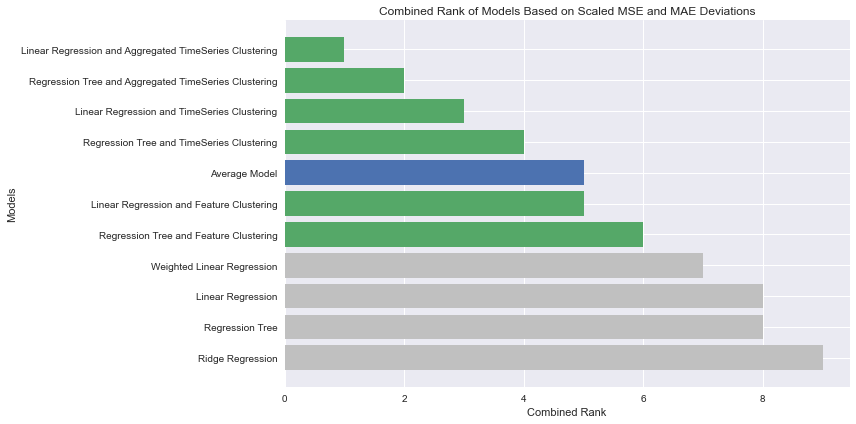

In [44]:
# Define the benchmark model's MSE and MAE (Average Model)
benchmark_mse = mse_values['Average_model_MSE']
benchmark_mae = mae_values['Average_model_MAE']

# Calculate the percentage deviation from the benchmark for MSE
# This measures how much each model's MSE deviates from the benchmark model's MSE
mse_deviation = (mse_values / benchmark_mse - 1) * 100

# Calculate the percentage deviation from the benchmark for MAE
# This measures how much each model's MAE deviates from the benchmark model's MAE
mae_deviation = (mae_values / benchmark_mae- 1 ) * 100

# Rank the models based on their percentage deviations in ascending order
# A lower deviation rank indicates better performance
mse_rank = mse_deviation.rank(method='dense', ascending=True).astype(int).to_dict()
mae_rank = mae_deviation.rank(method='dense', ascending=True).astype(int).to_dict()

# Clean the model names by stripping '_MSE' and '_MAE' suffixes
# This allows for easy comparison between MSE and MAE ranks
mse_rank_cleaned = {model.replace('_MSE', ''): rank for model, rank in mse_rank.items()}
mae_rank_cleaned = {model.replace('_MAE', ''): rank for model, rank in mae_rank.items()}

# Combine the ranks by summing the MSE and MAE ranks for each model
# Models present in either MSE or MAE ranking lists are considered
combined_rank = {model: mse_rank_cleaned.get(model, float('inf')) + mae_rank_cleaned.get(model, float('inf'))
                 for model in set(mse_rank_cleaned) | set(mae_rank_cleaned)}

# Convert the combined ranks to a Series and rank them in ascending order
# This results in the final combined rank of models
combined_rank_series = pd.Series(combined_rank).rank(method='dense', ascending=True).astype(int).sort_values()

# Custom labels for models for better readability in the plot
custom_labels = {
    'Average_model': 'Average Model',
    'linear_model': 'Linear Regression',
    'weighted_linear_model': 'Weighted Linear Regression',
    'ridge_model': 'Ridge Regression',
    'decision_tree_model': 'Regression Tree',
    'Clustering_linear_reg + Cluster_features': 'Linear Regression and Feature Clustering',
    'Clustering_linear_reg + Cluster_per2_TimeSeries': 'Linear Regression and Aggregated TimeSeries Clustering',
    'Clustering_linear_reg + Cluster_TimeSeries': 'Linear Regression and TimeSeries Clustering',
    'Clustering_tree + Cluster_features': 'Regression Tree and Feature Clustering',
    'Clustering_tree + Cluster_per2_TimeSeries': 'Regression Tree and Aggregated TimeSeries Clustering',
    'Clustering_tree + Cluster_TimeSeries': 'Regression Tree and TimeSeries Clustering'
}

# Assign colors to models based on their types for visualization
colors = ['#55a868' if 'Clustering' in model else '#4c72b0' if 'Average_model' in model else "#C0C0C0"
          for model in combined_rank_series.index]

# Apply custom labels to the model indices in the combined rank Series
combined_rank_series.index = [custom_labels.get(model, model) for model in combined_rank_series.index]

# Plot the combined rank with different colors for each model
plt.figure(figsize=(12, 6))
plt.barh(combined_rank_series.index, combined_rank_series.values, color=colors)
plt.xlabel('Combined Rank')
plt.ylabel('Models')
plt.title('Combined Rank of Models Based on Scaled MSE and MAE Deviations')
plt.gca().invert_yaxis()  # Invert y-axis to have the best rank at the top
plt.tight_layout()

# Show the plot
plt.show()


### Example plot forecast

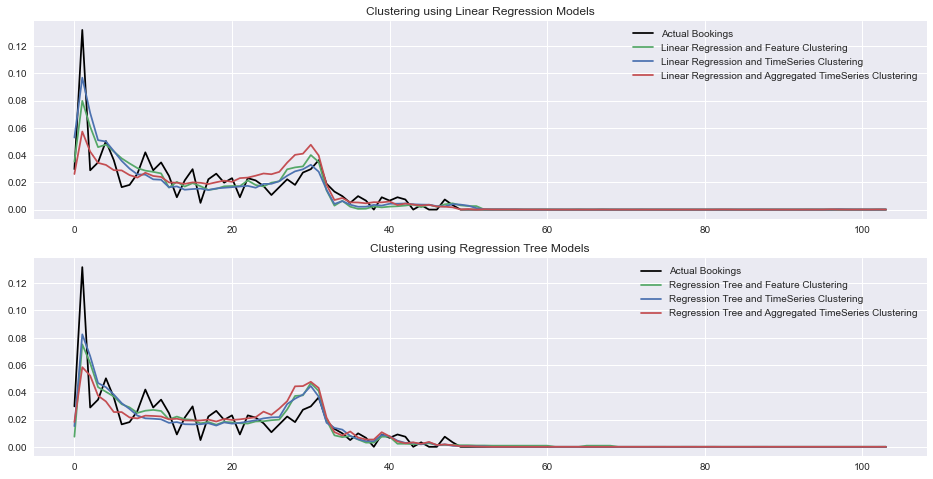

In [37]:
# Select the columns for linear regression and tree models
lr_columns = X_test[['BookingsList', 'Clustering_linear_reg + Cluster_features',
                     'Clustering_linear_reg + Cluster_TimeSeries', 'Clustering_linear_reg + Cluster_per2_TimeSeries']]

tree_columns = X_test[['BookingsList', 'Clustering_tree + Cluster_features',
                       'Clustering_tree + Cluster_TimeSeries', 'Clustering_tree + Cluster_per2_TimeSeries']]

# Define legend labels for linear regression models
lr_legend_labels = {
    'BookingsList': 'Actual Bookings',
    'Clustering_linear_reg + Cluster_features': 'Linear Regression and Feature Clustering',
    'Clustering_linear_reg + Cluster_TimeSeries': 'Linear Regression and TimeSeries Clustering',
    'Clustering_linear_reg + Cluster_per2_TimeSeries': 'Linear Regression and Aggregated TimeSeries Clustering'
}

# Define legend labels for tree models
tree_legend_labels = {
    'BookingsList': 'Actual Bookings',
    'Clustering_tree + Cluster_features': 'Regression Tree and Feature Clustering',
    'Clustering_tree + Cluster_TimeSeries': 'Regression Tree and TimeSeries Clustering',
    'Clustering_tree + Cluster_per2_TimeSeries': 'Regression Tree and Aggregated TimeSeries Clustering'
}

# Define colors to ensure consistency across plots
color_palette = {
    'BookingsList': 'black',
    'Clustering_linear_reg + Cluster_features': '#55a868',  # Same color for similar clustering
    'Clustering_linear_reg + Cluster_TimeSeries': '#4c72b0',
    'Clustering_linear_reg + Cluster_per2_TimeSeries': '#c44e52',
    'Clustering_tree + Cluster_features': '#55a868',  # Same color for similar clustering
    'Clustering_tree + Cluster_TimeSeries': '#4c72b0',
    'Clustering_tree + Cluster_per2_TimeSeries': '#c44e52'
}

# Create subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Select a random observation for plotting
observation = X_test.iloc[301]

# Plot for Clustering_LR models and BookingsList
for col in lr_columns.columns:
    sns.lineplot(data=observation[col], ax=axes[0], color=color_palette[col], label=lr_legend_labels[col])

# Set the title and legend for the first subplot
axes[0].set_title("Clustering using Linear Regression Models")
axes[0].legend()

# Plot for Clustering_Tree models and BookingsList
for col in tree_columns.columns:
    sns.lineplot(data=observation[col], ax=axes[1], color=color_palette[col], label=tree_legend_labels[col])

# Set the title and legend for the second subplot
axes[1].set_title("Clustering using Regression Tree Models")
axes[1].legend()

# Show the plot
plt.show()

In [38]:
print("done")

done
